# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any electorates over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("sportsvouchersclaimed.csv")

The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('ABS_SEIFA_LGA.csv')
seifa = seifa[seifa.LGA_2011.astype(str).str[0]=='4']
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga

<ipython-input-3-9cc930d247e6>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [4]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO

This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [5]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')

In [6]:
sa_vouchers_scores.groupby(['Participant_LGA']).mean()

,Participant_ID,Voucher_Value,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
Participant_LGA,,,,,,,,
ADELAIDE,1.029358e+06,50.000000,2015.894040,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1.051112e+06,49.951640,2015.793314,1083.0,1083.0,1077.0,1081.0,38601.0
ADELAIDE PLAINS,1.073646e+06,49.878754,2015.975528,NaN,NaN,NaN,NaN,NaN
ALEXANDRINA,1.071038e+06,49.946291,2015.883854,1000.0,1000.0,969.0,987.0,23693.0
BAROSSA,1.077192e+06,49.872999,2015.929715,1028.0,1028.0,997.0,1017.0,22174.0
...,...,...,...,...,...,...,...,...
WEST TORRENS,1.064404e+06,49.971871,2015.897328,949.0,949.0,989.0,998.0,54932.0
WHYALLA,1.120806e+06,48.370981,2015.930064,905.0,905.0,897.0,905.0,22070.0
WUDINNA,1.114339e+06,38.164794,2015.955056,1008.0,1008.0,999.0,1023.0,1256.0


Distribution of Vouchers in LGA's in SA:

Top 5:
ONKAPARINGA       12782
SALISBURY          8169
TEA TREE GULLY     7219
PLAYFORD           6940
CHARLES STURT      6897
Name: Participant_LGA, dtype: int64

Bottom 5:
FRANKLIN HARBOUR     155
ORROROO/CARRIETON    137
FLINDERS RANGES      102
PETERBOROUGH          45
COOBER PEDY           39
Name: Participant_LGA, dtype: int64


Number of vouchers distributed in LGA's:


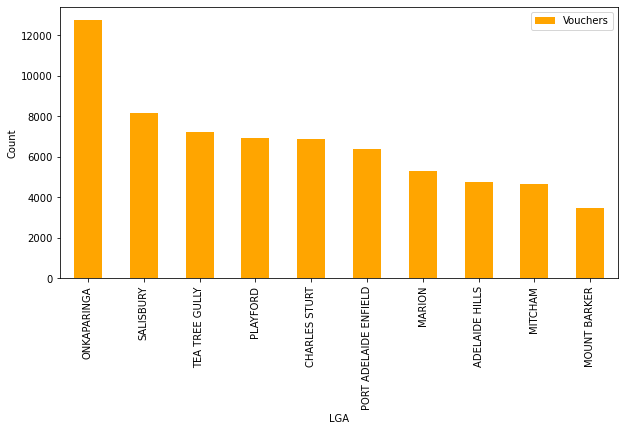

In [67]:
#Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?

print("Distribution of Vouchers in LGA's in SA:")
print("\nTop 5:")
print(sa_vouchers_scores.Participant_LGA.value_counts().head())
print("\nBottom 5:")
print(sa_vouchers_scores.Participant_LGA.value_counts().tail())

plt.figure(figsize=(10,5))
sa_vouchers_scores.Participant_LGA.value_counts().head(10).plot(kind="bar",color="orange",label="Vouchers")
plt.xlabel("LGA")
plt.ylabel("Count")
plt.legend()
print("\n\nNumber of vouchers distributed in LGA's:")



Number of vouchers distributed in LGA's (Total percentage):


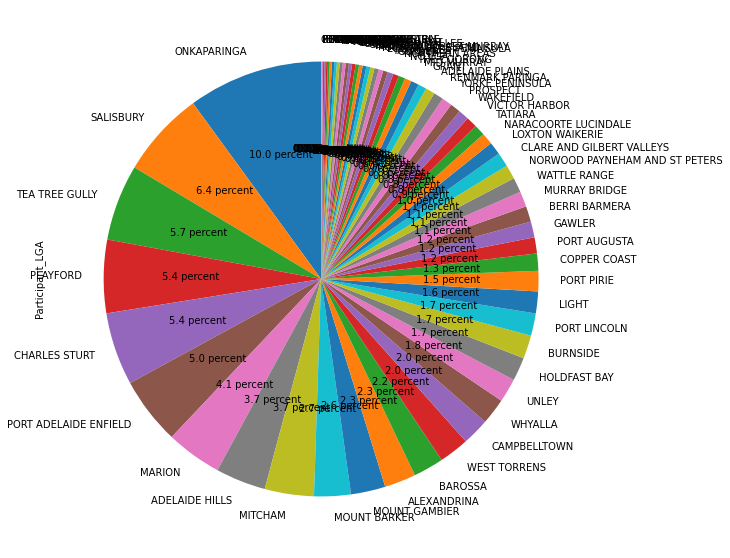

In [95]:
plt.figure(figsize=(10,10))
sa_vouchers_scores.Participant_LGA.value_counts().plot.pie(startangle=90,autopct="%.1f percent")
print("\n\nNumber of vouchers distributed in LGA's (Total percentage):")

Distribution of Vouchers redeemed for each sport:

Top 5:
Australian Rules     47224
Netball              24017
Football (Soccer)    15775
Gymnastics            9823
Basketball            6016
Name: Voucher_Sport, dtype: int64

Bottom 5:
Shooting            4
Paralympics         3
Dancesport          2
Bowls               2
Kung Fu (Wu Shu)    2
Name: Voucher_Sport, dtype: int64


Vouchers redeemed for each sport:


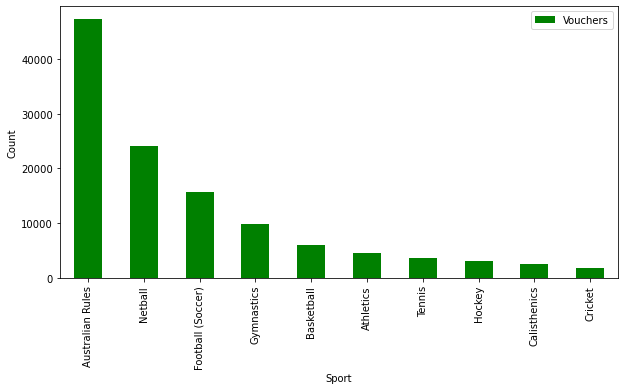

In [78]:
print("Distribution of Vouchers redeemed for each sport:")
print("\nTop 5:")
print(sa_vouchers_scores.Voucher_Sport.value_counts().head())
print("\nBottom 5:")
print(sa_vouchers_scores.Voucher_Sport.value_counts().tail())


plt.figure(figsize=(10,5))
sa_vouchers_scores.Voucher_Sport.value_counts().head(10).plot(kind="bar",color="green",label="Vouchers")
plt.xlabel("Sport")
plt.ylabel("Count")
plt.legend()
print("\n\nVouchers redeemed for each sport:")



Vouchers redeemed for each sport (Total percentage):


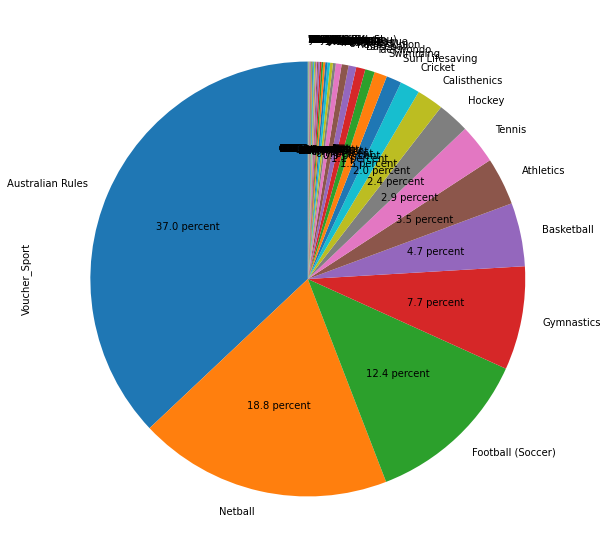

In [96]:
plt.figure(figsize=(10,10))
sa_vouchers_scores.Voucher_Sport.value_counts().plot.pie(startangle=90,autopct="%.1f percent")
print("\n\nVouchers redeemed for each sport (Total percentage):")

In [74]:
print("Number of Vouchers redeemed in each year:")
print(sa_vouchers_scores.Voucher_Claim_Year.value_counts())

Number of Vouchers redeemed in each year:
2016    51959
2015    43197
2017    32370
Name: Voucher_Claim_Year, dtype: int64


In [10]:
print("From the summary above, the regions (LGA's) with the highest uses of sport vouchers are ONKAPARINGA, followed by\n"
"SALISBURY, TEA TREE GULLY, PLAYFORD and CHARLES STURT. The most vouchers used for a sport are Australian Rules "
"followed by Netball, Football, Gymnastics and Basketball\n")

print("The sports with the lowest uses of sport vouchers are FRANKLIN HARBOUR then ORROROO/CARRIETON, FLINDERS RANGES \n"
"PETERBOROUGH and COOBER PEDY. The least vouchers used for a sport are Shooting, Paralymics, Bowls, Dancesport\nand Kung Fu")

From the summary above, the regions (LGA's) with the highest uses of sport vouchers are ONKAPARINGA, followed by
SALISBURY, TEA TREE GULLY, PLAYFORD and CHARLES STURT. The most vouchers used for a sport are Australian Rules followed by Netball, Football, Gymnastics and Basketball

The sports with the lowest uses of sport vouchers are FRANKLIN HARBOUR then ORROROO/CARRIETON, FLINDERS RANGES 
PETERBOROUGH and COOBER PEDY. The least vouchers used for a sport are Shooting, Paralymics, Bowls, Dancesport
and Kung Fu


In [11]:
#Are some sports more popular in different parts of the state?

Sport = [0] * len(sa_vouchers_scores.Participant_LGA.unique())
LGA_pop = [0] * len(sa_vouchers_scores.Participant_LGA.unique())

def most_popular_sport(LGA,i):
    while i < len(LGA):
        Sport[i] = sa_vouchers_scores[sa_vouchers_scores.Participant_LGA == LGA[i]].Voucher_Sport.value_counts().idxmax()
        LGA_pop[i] = LGA[i]
        i = i + 1
    

most_popular_sport(sa_vouchers_scores.Participant_LGA.unique(),0)
combine = [LGA_pop,Sport]
df = pd.DataFrame(data=combine)

Spread of most popular sports in each LGA:


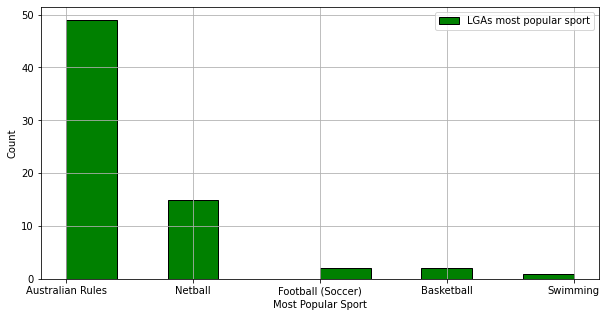

In [79]:
plt.figure(figsize=(10,5))
df.iloc[1].hist(color='green', edgecolor='black', label="LGAs most popular sport")
plt.xlabel('Most Popular Sport')
plt.ylabel('Count')
plt.legend()
print("Spread of most popular sports in each LGA:")

In [13]:
print("From the graph above, it is evident that some sports are more popular in different parts of the state. The "
      "most\nfrequently reported popular sport in an LGA is Australian Rules, followed by Netball with about 1/3 count of\n"
      "Australian Rules. Only a very few LGAs has reported Football (soccer), Basketball and Swimming as the most\npopular "
      "sport in their region, with each of these sports only reporting as the most popular sport in less\nthan 5 LGAs.")

From the graph above, it is evident that some sports are more popular in different parts of the state. The most
frequently reported popular sport in an LGA is Australian Rules, followed by Netball with about 1/3 count of
Australian Rules. Only a very few LGAs has reported Football (soccer), Basketball and Swimming as the most
popular sport in their region, with each of these sports only reporting as the most popular sport in less
than 5 LGAs.


In [14]:
#Are any electorates over/under represented in their use of vouchers? 

Elec = [0] * len(sa_vouchers_scores.Participant_Electorate.unique())
Population = [0] * len(sa_vouchers_scores.Participant_Electorate.unique())
Amount_vo = [0] * len(sa_vouchers_scores.Participant_Electorate.unique())
Voucher_Use_Percent = [0] * len(sa_vouchers_scores.Participant_Electorate.unique())

def represent(Electorate,i):
    while i < len(Electorate):
        Elec[i] = Electorate[i]
        Population[i] = sa_vouchers_scores[sa_vouchers_scores.Participant_Electorate == Electorate[i]].Population.max() #WRONG
        Amount_vo[i] = sa_vouchers_scores[sa_vouchers_scores.Participant_Electorate == Electorate[i]].value_counts().sum()
        Voucher_Use_Percent[i] = Amount_vo[i]/Population[i]
        i = i + 1

represent(sa_vouchers_scores.Participant_Electorate.unique(),0)
combine1 = [Elec,Population,Amount_vo,Voucher_Use_Percent]
df1 = pd.DataFrame(data=combine1)
df1 = df1.dropna(axis='columns') #drop nan values/no electorate
print("Representation of voucher use in Electorates:")
pd.set_option('display.max_columns', None)
df1

Representation of voucher use in Electorates:


,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,FISHER,ADELAIDE,GOYDER,CHELTENHAM,HEYSEN,KAURNA,FROME,CROYDON,MOUNT GAMBIER,STUART,SCHUBERT,FINNISS,GILES,TAYLOR,HAMMOND,ENFIELD,LIGHT,FLINDERS,ELDER,ASHFORD,BRAGG,MORIALTA,HARTLEY,MACKILLOP,CHAFFEY,KAVEL,NEWLAND,DAVENPORT,DUNSTAN,NAPIER,LEE,MAWSON,RAMSAY,BRIGHT,WEST TORRENS,PORT ADELAIDE,REYNELL,WAITE,MITCHELL,TORRENS,UNLEY,LITTLE PARA,COLTON,PLAYFORD,FLOREY,MORPHETT,WRIGHT
1,159517.0,19950.0,12929.0,112797.0,159517.0,159517.0,8750.0,112797.0,25254.0,13978.0,38601.0,159517.0,22070.0,129067.0,23693.0,112797.0,79082.0,14083.0,83005.0,83005.0,42168.0,95461.0,48182.0,11632.0,11266.0,38601.0,95461.0,159517.0,112797.0,79082.0,112797.0,159517.0,129067.0,83005.0,54932.0,129067.0,159517.0,62912.0,159517.0,112797.0,42168.0,129067.0,104922.0,129067.0,129067.0,104922.0,129067.0
2,3170,1543,2944,2521,6008,3561,2367,1684,4024,2893,3569,2926,3025,1849,2628,1046,2577,4155,1853,2518,2117,1936,1602,3074,2612,2964,2130,2405,379,3097,2373,2256,2548,2680,1545,2606,1676,1787,2475,1480,1595,4069,2056,2110,3119,1760,917
3,0.019872,0.077343,0.227705,0.02235,0.037664,0.022324,0.270514,0.014929,0.159341,0.206968,0.092459,0.018343,0.137064,0.014326,0.110919,0.009273,0.032586,0.295037,0.022324,0.030336,0.050204,0.020281,0.033249,0.264271,0.231848,0.076786,0.022313,0.015077,0.00336,0.039162,0.021038,0.014143,0.019742,0.032287,0.028126,0.020191,0.010507,0.028405,0.015516,0.013121,0.037825,0.031526,0.019596,0.016348,0.024166,0.016774,0.007105


Spread of Voucher use percentage (Vouchers redeemed vs Population) in each Electorate:


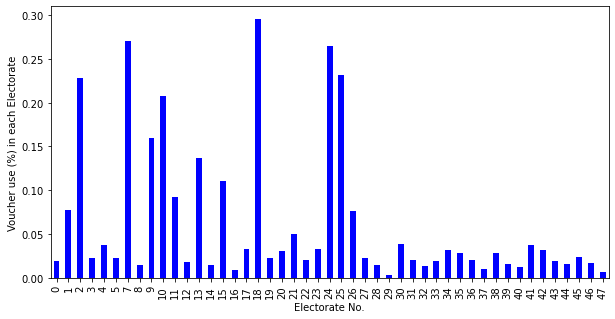

In [81]:
plt.figure(figsize=(10,5))
df1.iloc[3].plot(kind="bar",color='blue')
plt.ylabel('Voucher use (%) in each Electorate')
plt.xlabel('Electorate No.')
print("Spread of Voucher use percentage (Vouchers redeemed vs Population) in each Electorate:")

Spread of population in each Electorate:


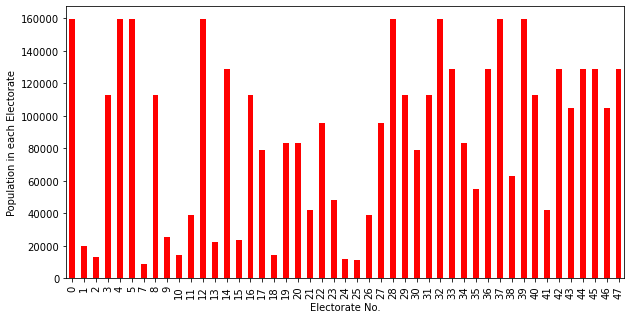

In [82]:
plt.figure(figsize=(10,5))
df1.iloc[1].plot(kind="bar",color='red')
plt.ylabel('Population in each Electorate')
plt.xlabel('Electorate No.')
print("Spread of population in each Electorate:")

Spread of voucher use in each Electorate:


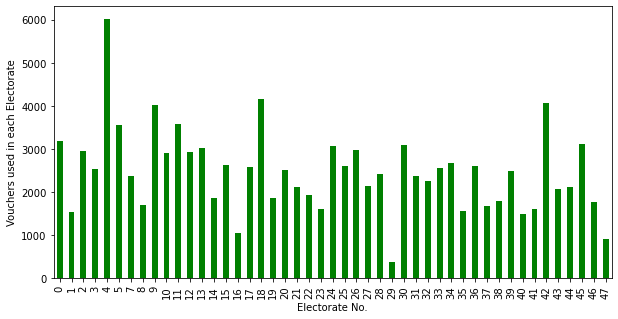

In [83]:
plt.figure(figsize=(10,5))
df1.iloc[2].plot(kind="bar",color='green')
plt.ylabel('Vouchers used in each Electorate')
plt.xlabel('Electorate No.')
print("Spread of voucher use in each Electorate:")

In [18]:
print("From the graphs above, ")

From the graphs above, 


In [19]:
#Is there a relationship between any of the SEIFA measures and voucher use in an LGA?
#IEO IER IRSAD IRSD ect.

IEO = [0] * len(sa_vouchers_scores.Participant_LGA.unique())
IER = [0] * len(sa_vouchers_scores.Participant_LGA.unique())
IRSAD = [0] * len(sa_vouchers_scores.Participant_LGA.unique())
IRSD = [0] * len(sa_vouchers_scores.Participant_LGA.unique())
Amount_vo = [0] * len(sa_vouchers_scores.Participant_LGA.unique())
LGA_pop = [0] * len(sa_vouchers_scores.Participant_LGA.unique())

def most_popular_sport(LGA,i):
    while i < len(LGA):
        LGA_pop[i] = LGA[i]
        Amount_vo[i] = sa_vouchers_scores[sa_vouchers_scores.Participant_LGA == LGA[i]].value_counts().sum()
        IEO[i] = Amount_vo[i]/sa_vouchers_scores[sa_vouchers_scores.Participant_LGA == LGA[i]].IEO.max()   
        IER[i] = Amount_vo[i]/sa_vouchers_scores[sa_vouchers_scores.Participant_LGA == LGA[i]].IER.max()  
        IRSAD[i] = Amount_vo[i]/sa_vouchers_scores[sa_vouchers_scores.Participant_LGA == LGA[i]].IRSAD.max()
        IRSD[i] = Amount_vo[i]/sa_vouchers_scores[sa_vouchers_scores.Participant_LGA == LGA[i]].IRSD.max()
        i = i + 1
    

most_popular_sport(sa_vouchers_scores.Participant_LGA.unique(),0)
combine = [LGA_pop,Amount_vo,IEO,IER,IRSAD,IRSD]
df2 = pd.DataFrame(data=combine)
print("Table of LGA:")
pd.set_option('display.max_columns', None)
df2 = df2.dropna(axis='columns') #drop nan values/no electorate
df2

Table of LGA:


,0,1,2,3,4,5,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,33,34,35,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68
0,ONKAPARINGA,ADELAIDE,YORKE PENINSULA,CHARLES STURT,PORT ADELAIDE ENFIELD,ADELAIDE HILLS,BARUNGA WEST,GRANT,CLARE AND GILBERT VALLEYS,BAROSSA,KANGAROO ISLAND,PLAYFORD,NORTHERN AREAS,ALEXANDRINA,MID MURRAY,GOYDER,CLEVE,MARION,WEST TORRENS,CAMPBELLTOWN,BURNSIDE,KINGSTON,MURRAY BRIDGE,WAKEFIELD,VICTOR HARBOR,KAROONDA EAST MURRAY,YANKALILLA,TATIARA,TEA TREE GULLY,MOUNT REMARKABLE,WATTLE RANGE,MITCHAM,UNLEY,MOUNT BARKER,PORT AUGUSTA,ROBE,SALISBURY,LOXTON WAIKERIE,COPPER COAST,LOWER EYRE PENINSULA,HOLDFAST BAY,KIMBA,TUMBY BAY,CEDUNA,ORROROO/CARRIETON,RENMARK PARINGA,STREAKY BAY,THE COORONG,PROSPECT,COOBER PEDY,FRANKLIN HARBOUR,ELLISTON,GAWLER,SOUTHERN MALLEE,WALKERVILLE,FLINDERS RANGES,WUDINNA,MOUNT GAMBIER,WHYALLA,PETERBOROUGH,PORT LINCOLN,ROXBY DOWNS
1,12673,296,975,6832,6280,4652,332,788,1234,2861,394,6773,537,2938,748,524,325,5231,2806,2513,2163,288,1454,978,1013,378,439,1048,7148,203,1378,4617,2221,3370,1522,167,8032,1193,1601,421,2193,211,294,301,137,899,278,629,971,39,155,165,1469,342,376,102,267,3236,2439,45,2101,234
2,12.723896,0.338673,1.006192,7.138976,6.818675,4.295476,0.33843,0.753346,1.230309,2.783074,0.401222,7.410284,0.542424,2.938,0.77513,0.539095,0.318315,5.370637,2.956797,2.538384,2.071839,0.291498,1.560086,1.005139,1.040041,0.378378,0.443434,1.034551,6.966862,0.205051,1.422085,4.435159,2.192498,3.252896,1.65976,0.164694,8.366667,1.241415,1.67644,0.407551,2.212916,0.203276,0.29727,0.319872,0.135913,0.95334,0.283963,0.651139,0.973922,0.044828,0.157681,0.168712,1.509764,0.343373,0.365403,0.105263,0.264881,3.475832,2.695028,0.051546,2.225636,0.219512
3,12.723896,0.338673,1.006192,7.138976,6.818675,4.295476,0.33843,0.753346,1.230309,2.783074,0.401222,7.410284,0.542424,2.938,0.77513,0.539095,0.318315,5.370637,2.956797,2.538384,2.071839,0.291498,1.560086,1.005139,1.040041,0.378378,0.443434,1.034551,6.966862,0.205051,1.422085,4.435159,2.192498,3.252896,1.65976,0.164694,8.366667,1.241415,1.67644,0.407551,2.212916,0.203276,0.29727,0.319872,0.135913,0.95334,0.283963,0.651139,0.973922,0.044828,0.157681,0.168712,1.509764,0.343373,0.365403,0.105263,0.264881,3.475832,2.695028,0.051546,2.225636,0.219512
4,12.997949,0.285714,1.045016,7.036045,6.759957,4.319406,0.353191,0.792757,1.254065,2.869609,0.409138,7.802995,0.556477,3.031992,0.815703,0.562836,0.326633,5.283838,2.837209,2.505484,1.984404,0.301571,1.639233,1.056156,1.068565,0.388889,0.458725,1.07377,7.01472,0.209278,1.486516,4.323034,2.073763,3.300686,1.696767,0.168687,8.692641,1.280043,1.759341,0.423541,2.12089,0.207066,0.305931,0.326464,0.139511,0.99118,0.288681,0.672727,0.933654,0.044879,0.162986,0.168712,1.543067,0.35149,0.349442,0.108051,0.267267,3.552141,2.719064,0.055693,2.256713,0.21547
5,12.762336,0.292201,1.02416,7.0,6.752688,4.303423,0.348008,0.774067,1.231537,2.813176,0.400814,7.776119,0.546843,2.976697,0.798292,0.556263,0.319253,5.231,2.811623,2.485658,2.000925,0.295385,1.613762,1.038217,1.046488,0.383367,0.451646,1.052209,6.89296,0.206511,1.45666,4.323034,2.085446,3.265504,1.679912,0.164857,8.572038,1.259768,1.727077,0.414778,2.110683,0.201914,0.3,0.322961,0.137966,0.981441,0.281092,0.662803,0.931862,0.044828,0.158974,0.166498,1.520704,0.346154,0.353052,0.106806,0.260997,3.490831,2.695028,0.056391,2.211579,0.213504


In [20]:
#df2.iloc[2].plot(kind="bar")


In [21]:
print("From the results above, ")

From the results above, 


## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [22]:
qld_vouchers = pd.read_csv('round1-redeemed_get_started_vouchers.csv')

In [23]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

<ipython-input-23-d688531e2bfc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,NaN,NaN,NaN,NaN,NaN
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN


In [24]:
#To do a comparable analysis you would need to map the activity names onto those from South Australia.
#COPY FROM PORT 2 + FORMAT